In [1]:
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns

In [ ]:
traffic_pd = pd.read_csv('../../Data/afterPreprocess.csv')
traffic_pd

# Độ tuổi của các đối tượng bị tai nạn

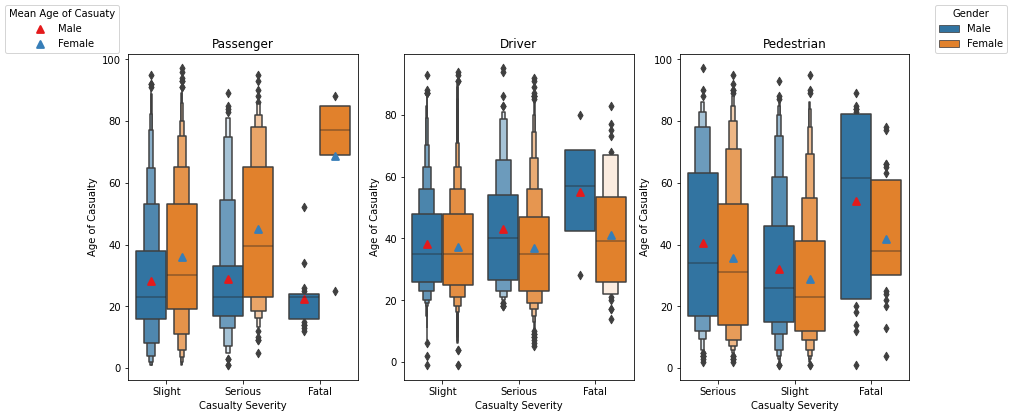

In [3]:
casualty_class = traffic_pd['Casualty Class'].unique()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
for i in range(len(casualty_class)):
    data_df = traffic_pd[traffic_pd['Casualty Class'] == casualty_class[i]]
    sns.boxenplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty', ax=axes[i])
    sns.pointplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty',
                  linestyles='None', errwidth=0, dodge=0.4, markers=['^', '^'], palette='Set1', ax=axes[i])
    
    axes[i].get_legend().remove()
    axes[i].set_title(casualty_class[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], title='Gender')
fig.legend(handles[2:], labels[2:], title='Mean Age of Casuaty', loc='upper left')

plt.show()

Có thể thấy trong cả 3 đối tượng bị tai nạn giao thông, độ tuổi trung bình của những nạn nhân nam thường thấp hơn so với nữ.
- Với mức độ nhẹ và nghiêm trọng:
    - Nam trong khoảng 20 - 40 tuổi thường bị tai nạn nhiều nhất
    - Với nữ thì trong khoảng 20 - 60 tuổi.
- Đặc biệt với các trường hợp người điều khiển phương tiện tử vong: nạn nhân nam vừa trẻ hơn và nhiều hơn so với nạn nhân nữ, có trường hợp trẻ nhất ~10 tuổi.

    $\rightarrow$ Điều này có thể do người điều khiển bị phương tiện khác gây tai nạn hay điều khiển phương tiện khi chưa đủ tuổi, không an toàn và gây tai nạn?
    
Ngược lại việc có nhiều người cao tuổi bị tai nạn là nữ hơn so với nam cũng có thể đặt nghi vấn như trên

# Vị trí của các vụ tai nạn

Trong tập dữ liệu có 2 trường `Grid Ref: Easting` và `Grid Ref: Northing` thể hiện tọa độ của nơi xảy ra vụ tai nạn. Tuy nhiên tọa độ này đang được biểu diễn dưới dạng Hệ thống tham chiếu lưới quốc gia của nước Anh, trong khi các công cụ trực quan chỉ làm việc tốt với hệ tọa độ kinh độ và vĩ độ. Ở phần này thực hiện các công việc:
- Chuyển đổi tọa độ về dạng kinh độ và vĩ độ.
- Sử dụng công cụ Tableau để trực quan các tọa độ được chuyển đổi ở trên.

## Chuyển đổi tọa độ

[Tham khảo: chuyển đổi giữa tọa độ Easting - Northing và kinh độ - vĩ độ](https://scipython.com/book/chapter-2-the-core-python-language-i/additional-problems/converting-between-an-os-grid-reference-and-longitudelatitude/)

In [7]:
import math

In [8]:
def scale_lat_coord(phi, F0=0.9996012717, a=6377563.396, b=6356256.909, phi0=math.radians(49)):
    n = (a - b) / (a + b)
    n2 = n ** 2; n3 = n ** 3
    dphi, sphi = phi - phi0, phi + phi0
    
    return (b * F0) * ((1 + n + (5/4)*(n2+n3)) * dphi
                      - ((3*n + 3*n2 + (21/8)*(n3)) * math.sin(dphi) * math.cos(sphi))
                      + (((15/8)*(n2) + (15/8)*(n3)) * math.sin(2*dphi) * math.cos(2*sphi))
                      - ((35/24)*(n3) * math.sin(3*dphi) * math.cos(3*sphi))
                      )

In [9]:
def grid_to_ll(grid, a=6377563.396, b=6356256.909, N0=-100000, F0=0.9996012717, lambda0=math.radians(-2), E0=400000):
    M = phip = 0
    e2 = (a**2 - b**2) / (a**2)
    
    while abs(grid[1] - N0 - M) >= 1e-5:
        phip += (grid[1] - N0 - M) / (a * F0)
        M = scale_lat_coord(phip)
        
    sin_phip2 = math.sin(phip)**2
    nu = (a * F0) / math.sqrt(1 - e2 * sin_phip2)
    rho = (a * F0) / ((1 - e2) / (1 - e2*sin_phip2)**(3/2))
    eta2 = (nu / rho) - 1
    
    tan_phip = math.tan(phip); tan_phip2 = tan_phip**2
    sec_phip = 1 / math.cos(phip)
    
    c1 = tan_phip / (2*rho*nu)
    c2 = tan_phip / (24*rho*nu**3) * (5 + (3 - 9*eta2)*tan_phip2 + eta2)
    c3 = tan_phip / (720*rho*nu**5) * (61 + (90 + 45*tan_phip2)*tan_phip2)
    
    d1 = sec_phip / nu
    d2 = sec_phip / (6*nu**3) * ((nu / rho) + 2*tan_phip2)
    d3 = sec_phip / (120*nu**5) * (5 + (28 + 24*tan_phip2)*tan_phip2)
    d4 = sec_phip / (5040*nu**7) * (61 + (662 + (1320 + 720*tan_phip2)*tan_phip2)*tan_phip2)
    
    e_e0 = grid[0] - E0; e_e0_2 = e_e0**2
    phi = phip - (c1 + (c2 - c3*e_e0_2)*e_e0_2)*e_e0_2
    lamb = lambda0 + (d1 + (-d2 + (d3 - d4*e_e0_2)*e_e0_2)*e_e0_2)*e_e0
    
    return (math.degrees(phi), math.degrees(lamb))

In [10]:
years = list(range(2014, 2020))
for year in years:
    traffic_year = traffic_pd[traffic_pd['Accident Date'].str.contains(str(year), regex=False)]
    coords = traffic_year[['Grid Ref: Easting', 'Grid Ref: Northing']].apply(grid_to_ll, axis=1)
    
    file = open(f'coord_{year}.csv', 'w', encoding='utf-8')
    file.write('Latitude,Longitude\n')

    for c in coords:
        file.write(f'{c[0]},{c[1]}\n')

    file.close()

## Trực quan các vị trí xảy ra tai nạn

Dưới đây thể hiện kết quả trực quan vị trí các vụ tai nạn với tọa độ (kinh độ, vĩ độ) được tính ở trên. Sử dụng công cụ `Tableau` để trực quan.

### Năm 2014
![2014.png](../../Data/2014.png)

### Năm 2015

![2015.png](../../Data/2015.png)

### Năm 2016

![2016.png](../../Data/2016.png)

### Năm 2017

![2017.png](../../Data/2017.png)

### Năm 2018

![2018.png](../../Data/2018.png)

### Năm 2019

![2019.png](../../Data/2019.png)

# Những khu vực tập trung nhiều vụ tai nạn nhất?

Qua phần trực quan vị trí các vụ tai nạn trong giai đoạn 2014-2019 ở thành phố Leeds, West Yorkshire, Yorkshire and the Humber, Anh, nhóm nhận thấy dường như các vụ tai nạn thường xảy ra tập trung hơn ở khu vực các quận trung tâm thành phố. Tuy nhiên bản đồ ở trên chỉ thể hiện mức chung chung, nếu phóng to quá cụ thể vào từng con đường, quận/huyện thì không thể bao quát tất cả các vị trí, thêm nữa giai đoạn 5 năm này có đến hơn 13000 vụ tai nạn xảy ra trong thành phố. Vì vậy chỉ với phần trực quan như trên là không đủ để kết luận rằng khu vực nào trong thành phố tập trung các vụ tai nạn nhiều hơn so với khu vực khác.

Ở phần này nhóm sẽ tập trung vào 2 trường dữ liệu thể hiện vị trí của các vụ tai nạn. Trang [gridreferencefinder](https://gridreferencefinder.com/) cung cấp công cụ để tìm kiếm vị trí dựa trên Hệ quy chiếu lưới quốc gia Anh. Có rất nhiều điểm xãy ra vụ tai nạn - cụ thể đếm được 10105 tọa độ khác nhau - làm cho việc tìm kiếm địa chỉ mất rất nhiều thời gian. Nhưng nếu gom các vị trí trên thành các nhóm, sau đó tìm kiếm vị trí của tâm nhóm và số lượng phần tử thuộc mỗi nhóm thì ta có thể có dược thông tin về mức độ tập trung tai nạn nhanh hơn.

Trong phần này nhóm áp dụng thuật toán gom nhóm để trả lời câu hỏi trên. Các bước thực hiện bao gồm:
- Gom nhóm các vị trí xảy ra tai nạn thành các cụm. Sử dụng độ đo để đánh giá kết quả gom nhóm và chọn ra cách gom nhóm tốt nhất.
- Tìm vị trí các tâm cụm trên bản đồ và lấy ra tên đường/quận/huyện.
- Đếm số lượng những vụ tai nạn xảy ra trong cụm đó.

In [2]:
traffic_coords = pd.read_csv('../../Data/afterPreprocess.csv', usecols=['Grid Ref: Easting', 'Grid Ref: Northing'])
traffic_coords.value_counts()

Grid Ref: Easting  Grid Ref: Northing
430846             434032                13
435431             439805                12
430875             433474                11
429137             435242                11
427506             425505                11
                                         ..
428665             437012                 1
428664             437012                 1
428659             433169                 1
428656             430027                 1
445976             431196                 1
Length: 10105, dtype: int64

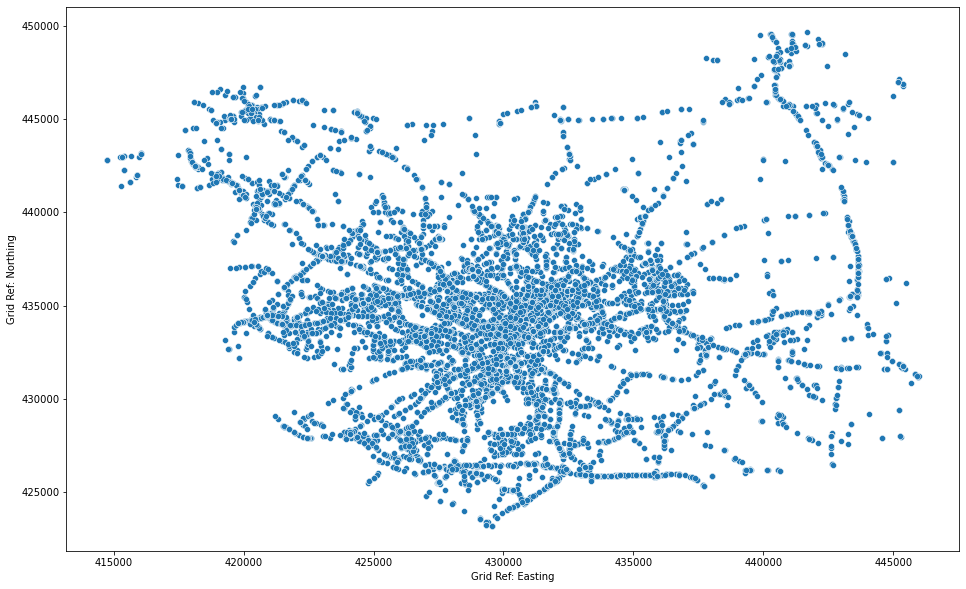

In [4]:
fig, ax = plt.subplots(figsize=(16, 10))
# sns.scatterplot(data=traffic_17, x='Latitude', y='Longitude', ax=ax)
sns.scatterplot(data=traffic_coords, x='Grid Ref: Easting', y='Grid Ref: Northing', ax=ax)
fig.show()

### Gom nhóm các vị trí xảy ra tai nạn

Một vấn đề khi gom nhóm những điểm dữ liệu trên là chọn số cụm sao cho hợp lý nhất, vì vậy ngoài việc chọn số cụm thì nhóm còn phải đánh giá lựa chọn đó như thế nào so với những lựa chọn khác. Thêm vào đó nguồn dữ liệu không thực hiện gom nhóm các điểm dữ liệu nên các điểm dữ liệu không có kết quả gom nhóm đúng, do đó cần độ đo đánh giá kết quả phân cụm mà không cần phải có phân cụm đúng của dữ liệu.

Thử nghiệm phân cụm với số phân cụm từ 2 đến 20 và sử dụng độ đo Silhouette và Davies-Bouldin để đánh giá kết quả phân cụm. Việc sử dụng nhiều hơn 1 độ đo tạo cơ sở để đối chiếu kết quả, từ đó có thể chọn ra số phân cụm hợp lý nhất. Trong đó:
- Với độ đo Silhouette: giá trị trong đoạn $[-1, 1]$. Kết quả càng cao thì mô hình định nghĩa các cụm tốt hơn.
- Với độ đo Davies-Bouldin: giá trị trong đoạn $[0, \infty)$. Mô hình gom nhóm có kết quả càng gần 0 thì càng phân cụm tốt.

Tham khảo:
- https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

cluster_model = KMeans(max_iter=1000, random_state=0)

In [4]:
%%time
n_clusters = list(range(2, 21))
labels = []
for k in n_clusters:
    cluster_model.set_params(n_clusters=k)
    labels.append(cluster_model.fit_predict(traffic_coords))

CPU times: user 56.8 s, sys: 3.93 s, total: 1min
Wall time: 7.56 s


In [5]:
%%time
silhouette_scores = [silhouette_score(traffic_coords, l, random_state=42) for l in labels]

CPU times: user 31.8 s, sys: 4.93 s, total: 36.7 s
Wall time: 37 s


In [6]:
%%time
davies_bouldin_scores = [davies_bouldin_score(traffic_coords, l) for l in labels]

CPU times: user 135 ms, sys: 0 ns, total: 135 ms
Wall time: 150 ms


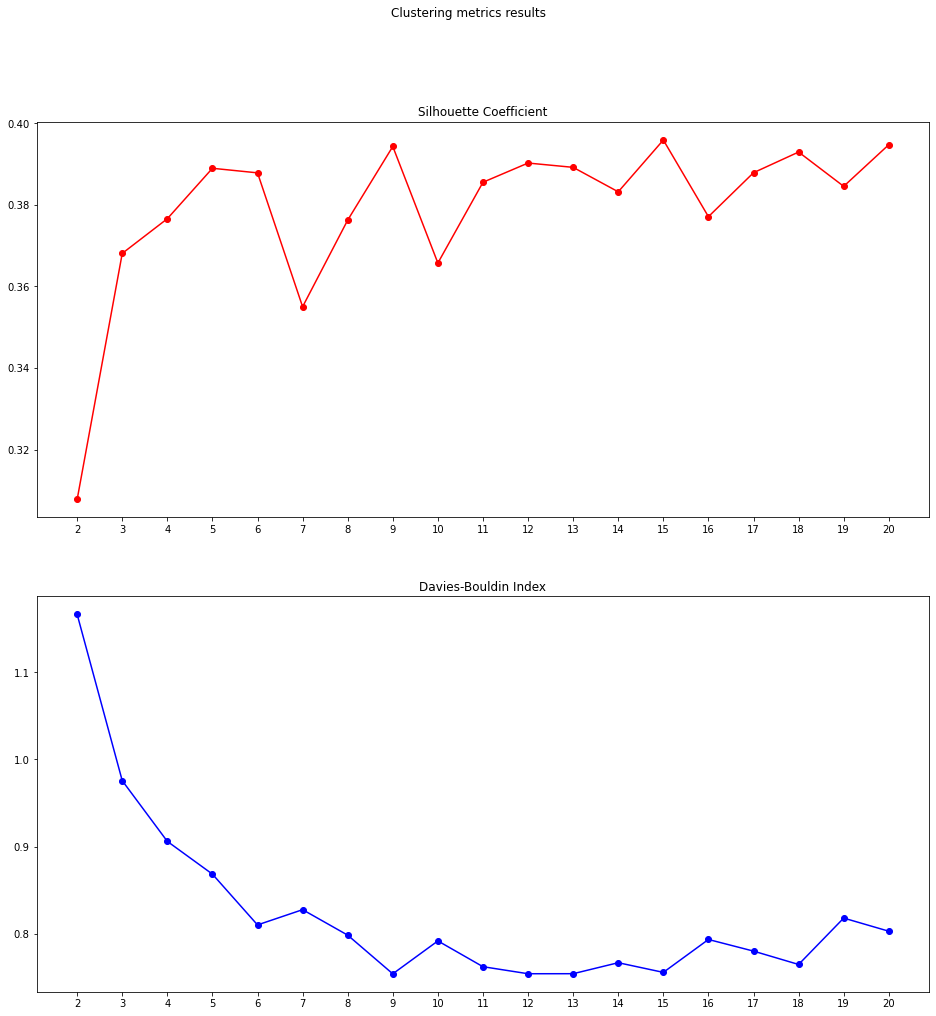

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(16, 16))
fig.suptitle('Clustering metrics results')

plt.sca(ax[0])
plt.plot(n_clusters, silhouette_scores, 'o-r')
plt.xticks(n_clusters)
plt.title('Silhouette Coefficient')

plt.sca(ax[1])
plt.plot(n_clusters, davies_bouldin_scores, 'o-b')
plt.xticks(n_clusters)
plt.title('Davies-Bouldin Index')

fig.show()

In [8]:
plt.close(fig)

In [9]:
print(f'Best n_clusters (highest Silhouette Coefficient): {n_clusters[silhouette_scores.index(max(silhouette_scores))]}')
print(f'\tSilhouette Coefficient = {max(silhouette_scores)}')
print()

print(f'Best n_clusters (lowest Davies-Bouldin Index): {n_clusters[davies_bouldin_scores.index(min(davies_bouldin_scores))]}')
print(f'\tDavies-Bouldin Index = {min(davies_bouldin_scores)}')

Best n_clusters (highest Silhouette Coefficient): 15
	Silhouette Coefficient = 0.39589042321923307

Best n_clusters (lowest Davies-Bouldin Index): 9
	Davies-Bouldin Index = 0.7538851912787473


Có thể thấy 2 độ đo trên cho kết quả khác nhau về số phân cụm nào là tốt nhất. Đáng chú ý là số nhóm là 9 và 15 đều được đánh giá tốt hơn so với các lựa chọn khác theo cách tính của cả 2 độ đo, và chênh lệch giữa điểm số của 9 và 15 cụm là không nhiều. 

Tính cụ thể chêch lệch điểm số giữa 2 lựa chọn.

In [19]:
n_15_idx = n_clusters.index(15)
n_9_idx = n_clusters.index(9)

print('Difference between scores of 9 & 15 clusters:')
print('Silhouette Coefficient: ', end='')
print(abs(silhouette_scores[n_15_idx] - silhouette_scores[n_9_idx]))

print('Davies-Bouldin Index: ', end='')
print(abs(davies_bouldin_scores[n_15_idx] - davies_bouldin_scores[n_9_idx]))

Difference between scores of 9 & 15 clusters:
Silhouette Coefficient: 0.0015875010414521107
Davies-Bouldin Index: 0.0016648420813539788


Chênh lệch điểm số của 9 và 15 phân cụm thể hiện rằng chất lượng của cả 2 là rất gần với nhau, việc chọn 9 hay 15 phân cụm không có gì quá khác biệt.

> Như vậy nhóm chọn 9 phân cụm để thực hiện gom nhóm các vị trí xảy ra tai nạn. Tuy 2 độ đo có ý kiến khác nhau về việc 9 phân cụm là tốt nhất nhưng phân thành 9 cụm thì đơn giản hơn so với 15 cụm và kết quả đánh giá chỉ chênh nhau ~0.0015.

### Tìm vị trí các tâm cụm

Truy cập trang [gridreferencefinder](https://gridreferencefinder.com/) tìm kiếm địa chỉ các vị trí tâm cụm và lưu vào file csv. Sau đó đếm số điểm dữ liệu được xếp vào từng cụm và sắp xếp giảm dần.

In [20]:
cluster_model.set_params(n_clusters=9)
traffic_coords['Labels'] = cluster_model.fit_predict(traffic_coords)

(cluster_model.cluster_centers_).round(0)

array([[429500., 433274.],
       [433367., 435557.],
       [420725., 442697.],
       [440515., 445030.],
       [433153., 427609.],
       [441236., 433044.],
       [426973., 427964.],
       [428913., 438595.],
       [423938., 435047.]])

[**Kết quả tìm kiếm các vị trí tâm cụm**](https://gridreferencefinder.com?gr=SE2950033274|429500_s__c__s_433274|1,SE3336735557|433367_s__c__s_435557|1,SE2072542697|420725_s__c__s_442697|1,SE3315327609|433153_s__c__s_427609|1,SE4123633044|441236_s__c__s_433044|1,SE2697327964|426973_s__c__s_427964|1,SE2891338595|428913_s__c__s_438595|1,SE2393835047|423938_s__c__s_435047|1,SE4051545030|440515_s__c__s_445030|1&v=r&labels=1)

In [21]:
import re

In [22]:
address_df = pd.read_csv('../../Data/address.csv', usecols=['Address (near)'])
address_df['Counts'] = (traffic_coords.groupby('Labels').size())

pd.options.display.max_colwidth = None
address_df.sort_values('Counts', ascending=False, inplace=True)

address_df['Address (near)'] = address_df['Address (near)'].apply(lambda x: x[:re.search('Leeds', x).start() - 2])
address_df.index.set_names('Labels', inplace=True)
address_df

,Address (near),Counts
Labels,,
0,"Whitehall Riverside, Holbeck Urban Village",4183
1,"Amberton Approach, Gipton",2414
8,"Compton Lane, Collingham",1629
6,"Ring Road Meanwood, Moor Allerton",1315
7,"Bramley Service Reservoir, Fairfield Square, Fairfield Estate, Bramley, Pudsey",1264
4,"Cricketers Close, Garforth",1225
5,"Miners Fisheries, 2a, Clough Street, Morley",725
2,"West Carlton, Carlton, Yeadon",711
3,"Leadwell Lane Northfield Avenue, Leadwell Lane, Howlett Cross, Carlton",373


### Trực quan kết quả gom nhóm các điểm dữ liệu.

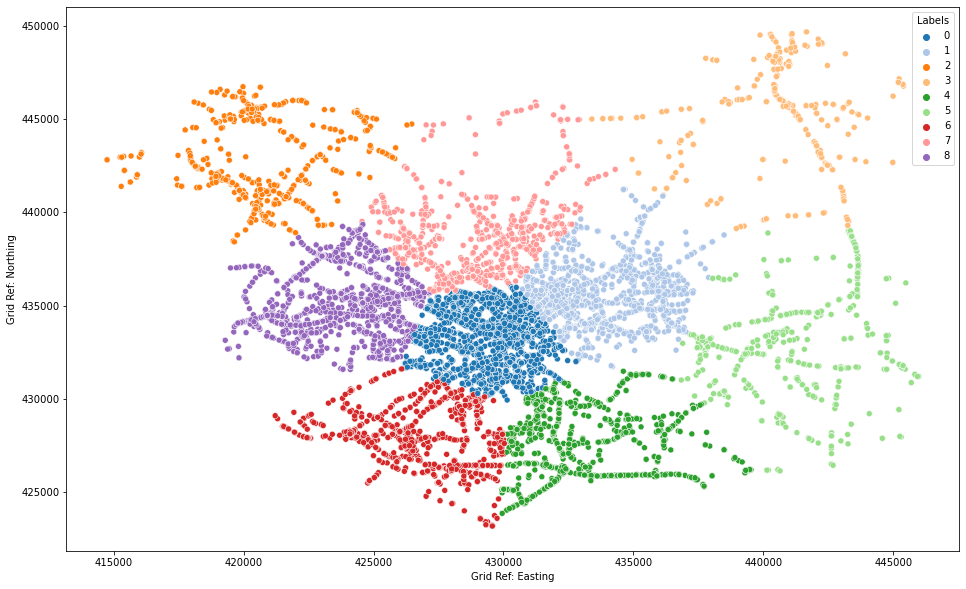

In [27]:
fig, ax = plt.subplots(figsize=(16, 10))
# sns.scatterplot(data=traffic_17, x='Latitude', y='Longitude', ax=ax, hue='Labels', palette='Paired')
sns.scatterplot(data=traffic_coords, x='Grid Ref: Easting', y='Grid Ref: Northing', hue='Labels', palette='tab20', ax=ax)
fig.show()

In [28]:
plt.close(fig)